In [296]:
# Import libraries

# For data processing
import glob
import numpy
import datetime
import pandas as pd    
import os.path, time
from dateutil.parser import parse

# For topic modelling
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Visualising topics using tSNE and PCA
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Implementing LSI Model using gensim package
from gensim.corpora.dictionary import Dictionary
from gensim.models import LsiModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel

# Word clouds
from wordcloud import WordCloud

# For sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from IPython.display import clear_output

In [297]:
# Set seed
numpy.random.seed(30224)

In [288]:
############## DO NOT RUN THIS CODE BLOCK ##############

# The original raw dataset used for this project has two different formats based on when it was captured. 
# All the conversations before and after 11th May 2022 have different formats.

# List file names
file_names = glob.glob("data/*jsonl")

# This requires separate pre-processing steps.
# But before we do that, let's capture the file names in two separate lists.

old_format_files = []
new_format_files = []

for file_name in file_names:
    if datetime.datetime.fromtimestamp(os.path.getmtime(file_name)) <= parse("2022-05-11 18:51:06+00:00").replace(tzinfo=None):
        old_format_files.append(file_name)
    else:
        new_format_files.append(file_name)

######### Old format #########

# We are only interested in conversations initiated by end users. Not admins or bots.
# We start off by reading through each file in the old format and 
# checking whether the conversations are started by end user or not.
# Then, we select the columns that are most interesting to us.

def is_conversation_by_user(row) -> bool:
    """
    Check whether a conversation is started by the end user or not
    """
    try:
        return (row["conversation_message"]["author"]["type"] == "user") and (row["type"] == "conversation")
    except KeyError:
        return False

old_format_conversations = []
for count, file_name in enumerate(old_format_files):
    # Read a json as pandas dataframe
    conversations = pd.read_json(path_or_buf=file_name, lines=True)

    # Filter the conversations based on whether they were initiated by the user
    is_user_conversations = conversations.apply(is_conversation_by_user, axis=1)
    if not sum(is_user_conversations):
        continue
    user_conversations = conversations[is_user_conversations]

    # Select important columns
    user_conversations = user_conversations[["id", "user", "updated_at", "conversation_message", "conversation_parts", "state"]]
    old_format_conversations.append(user_conversations)


# Combine all files data into a single dataframe
old_format_conversations_df = pd.concat(old_format_conversations, ignore_index = True)

def clean_conversation_parts(row):
    """
    This function cleans the conversation thread and returns a list of tuple in the following format - (<Author>, <Message>)
    """
    conversation_parts = []
    for conversation_part in row["conversation_parts"]:
        if conversation_part["part_type"] == "comment" and conversation_part["body"] is not None:
            conversation_parts.append((conversation_part["author"]["type"], conversation_part["body"]))
    return conversation_parts

old_format_conversations_df['conversation_parts'] = old_format_conversations_df.apply(clean_conversation_parts, axis=1)

def clean_conversation_message(row):
    """
    This function extracts the main message sent by the end-user
    """
    return row["conversation_message"]["body"]

old_format_conversations_df['conversation_message'] = old_format_conversations_df.apply(clean_conversation_message, axis=1)

def clean_user(row):
    """
    This function extracts the user id
    """
    return row["user"]["id"]

old_format_conversations_df['user'] = old_format_conversations_df.apply(clean_user, axis=1)

######### New format #########

# We are only interested in conversations initiated by end users. Not admins or bots.
# We start off by reading through each file in the old format and 
# checking whether the conversations are started by end user or not.
# Then, we select the columns that are most interesting to us.

def is_conversation_by_user(row) -> bool:
    """
    Check whether a conversation is started by the end user or not
    """
    try:
        return (row["source"]["author"]["type"] == "user") and (row["source"]["type"] == "conversation")
    except KeyError:
        return False

new_format_conversations = []
for count, file_name in enumerate(new_format_files):
    # Read a json as pandas dataframe
    conversations = pd.read_json(path_or_buf=file_name, lines=True)

    # Filter the conversations based on whether they were initiated by the user
    is_user_conversations = conversations.apply(is_conversation_by_user, axis=1)
    if not sum(is_user_conversations):
        continue
    user_conversations = conversations[is_user_conversations]

    # Select important columns
    user_conversations = user_conversations[["id", "updated_at", "source", "state"]]
    new_format_conversations.append(user_conversations)

# Combine all files data into a single dataframe
new_format_conversations_df = pd.concat(new_format_conversations, ignore_index = True)

# In the new format data, there are no conversation threads recorded. So, initialise them as None.
new_format_conversations_df['conversation_parts'] = None

def clean_conversation_message(row):
    """
    This function cleans the main conversation started by the end user.
    """
    return row["source"]["body"].replace("<p>", "").replace("</p>", "")

new_format_conversations_df['conversation_message'] = new_format_conversations_df.apply(clean_conversation_message, axis=1)

def clean_user(row):
    """
    This function extracts the user id
    """
    return row["source"]["author"]["id"]

new_format_conversations_df['user'] = new_format_conversations_df.apply(clean_user, axis=1)

# Remove the unwanted column
new_format_conversations_df = new_format_conversations_df.drop('source', axis=1)

# Combine the old format dataframe and new format datagrame
all_conversations_df = pd.concat([old_format_conversations_df, new_format_conversations_df])

# Store the final dataset as a csv
all_conversations_df.to_csv('all_conversations_df.csv')

In [ ]:
# Import the cleaned and processed conversations
all_conversations_df = pd.read_csv("all_conversations_df.csv")

In [289]:
# Topic modelling

# Create a single column that combines/ concatenates all the thread messages with the main message from the user per interaction as one string.
def combine_thread_messages(row) -> str:
    text = " "
    if row["conversation_parts"]:
        if row["conversation_message"] in ["I have a question about my existing loan", "Ask something else..."]:
            text = " "
        else:
            text = row["conversation_message"] + " "
        for conversation_part in row["conversation_parts"]:
            if conversation_part[0] == "user" and conversation_part[1] not in ["Ask something else...", "Talk to a person 👤"]:
                text += conversation_part[1] + " "
        return text
    return row["conversation_message"]

# Create a copy of all conversations 
topic_modelling_df = all_conversations_df

# Add a new column that has a single text column - conversation
topic_modelling_df["conversation"] = topic_modelling_df.apply(combine_thread_messages, axis=1)

# Remove rows without any useful info (chat bot buttons and no threads)
topic_modelling_df = topic_modelling_df.loc[~topic_modelling_df["conversation"].isin(["Ask something else...", "I have a question about my existing loan", "I have a question about my eligibility check"])]

# Remove rows that have "Outbound" text in the conversation. 
topic_modelling_df = topic_modelling_df[~topic_modelling_df['conversation'].str.contains("Outbound")]

In [291]:
def preprocess_description(text):
    """
    Implement various text cleaning strategies
    """
    # Convert text to lowercase
    text = text.lower().replace("[^a-zA-Z#]", " ")
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove punctuation
    punctuation = set(string.punctuation + "’")
    tokens = [word for word in tokens if word not in punctuation]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Remove numbers (any tokens that consist only of digits)
    tokens = [word for word in tokens if not word.isdigit()]
    
    # Remove very short words
    tokens = [word for word in tokens if len(word) > 3]

    # Remove words that do not add any value addition
    tokens = [word for word in tokens if word not in ["like", "thanks"]]
    
    # Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

# Create a new column called "clean_conversation" that free of punctuation, stop words, short words, lemmatization applied.
topic_modelling_df["clean_conversation"] = topic_modelling_df['conversation'].apply(lambda x: preprocess_description(x))

# There are some conversations that are automated comms triggered by the system. 
# For eg - If a user missed a voicemail or a call, it creates a new row as a conversation
# Such cases are not at all useful for our analysis, hence, we remove them.
topic_modelling_df = topic_modelling_df[~topic_modelling_df['clean_conversation'].str.contains("voicemail")]
topic_modelling_df = topic_modelling_df[~topic_modelling_df['clean_conversation'].str.contains("mobile")]
topic_modelling_df = topic_modelling_df[~topic_modelling_df['clean_conversation'].str.contains("updraft main")]
topic_modelling_df = topic_modelling_df[~topic_modelling_df['clean_conversation'].str.contains("inbound")]
topic_modelling_df = topic_modelling_df[~topic_modelling_df['clean_conversation'].str.contains("missed call london number")]

# Finally, remove conversations that are less than 3 words.
topic_modelling_df = topic_modelling_df[topic_modelling_df.clean_conversation.str.count(' ').ge(2)]

In [312]:
def perform_lsa(conversations, n_topics):
    """
    This function implements Latent Semantic Analysis - 
    1. Convert the conversations to TF-IDF
    2. Fit Singular Value Decomposition to the vectors
    3. Get the components and sort them for each topic

    This function also assigns a topic to each conversation in the corpus 
    based on the maximum value of the svd model output
    """
    # Calculate TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df = 0.5, smooth_idf=True)
    
    X = vectorizer.fit_transform(conversations)
    
    # SVD represent documents and terms in vectors 
    svd_model = TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=100, random_state=122)
    svd_model.fit(X)
    
    # Get the top 5 most important tokens per topic
    terms = vectorizer.get_feature_names_out()

    # Get the topic 
    X_topics = svd_model.fit_transform(X)
    predicted_topic = []
    for X_topic in X_topics:
        X_topic = list(X_topic)
        predicted_topic.append(X_topic.index(max(X_topic)))
    
    for i, comp in enumerate(svd_model.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:8]
        print("\nTopic "+str(i+1)+": \n")
        for t in sorted_terms:
            print(t[0])
    
    return predicted_topic

In [315]:
# Run LSA on clean conversations column with assumed number of topics as 5
predicted_topic = perform_lsa(topic_modelling_df['clean_conversation'], 5)

# Add a new column "topic" to the dataset
topic_modelling_df["topic"] = predicted_topic

# As the topic vectors start from index 0, we add 1 to it for easier comprehension.
topic_modelling_df["topic"] = topic_modelling_df["topic"] + 1


Topic 1: 

loan
settlement
payment
figure
month
account
thank
debit

Topic 2: 

settlement
figure
early
settle
today
provide
quote
request

Topic 3: 

question
loan
offer
eligibility
check
long
decision
credit

Topic 4: 

loan
increase
month
payment
offer
holiday
possible
existing

Topic 5: 

question
change
date
offer
direct
debit
loan
eligibility


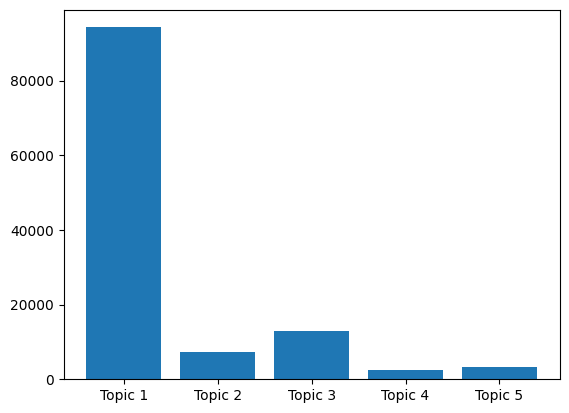

In [316]:
# Get count of each topics in the corpus
list(Counter(predicted_topic).values()) 

# Create a dictionary of output
D = {"Topic 1": 94270, "Topic 2": 7265, "Topic 3": 12874, "Topic 4": 2596, "Topic 5": 3228}

###### Fig. 2 in the report ########
# Plot the bar chart 
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

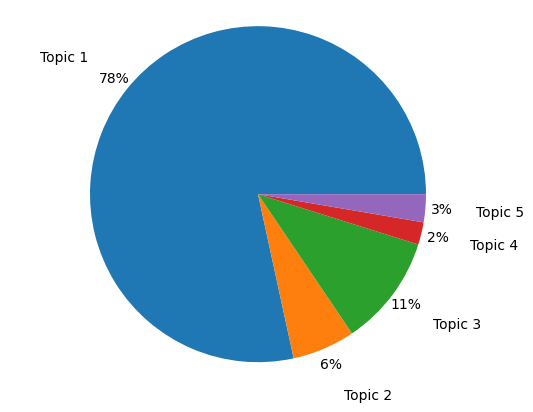

In [317]:
###### Fig. 3 in the report ########

# Plot the above bar plot as pie chart in terms of percentage
labels = []
sizes = []
for x, y in D.items():
    labels.append(x)
    sizes.append(y)


plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.axis('equal')
plt.show()

In [46]:
# In this section, we implement tSNE on topic vectors to be able to visualise them 
# in 2-D and see similarity and dissimilarity between the topics

# Implement tSNE to convert the topic vectors to 2-dimensional dataset
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_topics)

tsne_df = pd.DataFrame(tsne_results, columns=["tsne_1", "tsne_2"])
tsne_df["topic"] = np.array(topic_modelling_df["topic"])
tsne_df

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 120233 samples in 0.044s...
[t-SNE] Computed neighbors for 120233 samples in 3.786s...
[t-SNE] Computed conditional probabilities for sample 1000 / 120233
[t-SNE] Computed conditional probabilities for sample 2000 / 120233
[t-SNE] Computed conditional probabilities for sample 3000 / 120233
[t-SNE] Computed conditional probabilities for sample 4000 / 120233
[t-SNE] Computed conditional probabilities for sample 5000 / 120233
[t-SNE] Computed conditional probabilities for sample 6000 / 120233
[t-SNE] Computed conditional probabilities for sample 7000 / 120233
[t-SNE] Computed conditional probabilities for sample 8000 / 120233
[t-SNE] Computed conditional probabilities for sample 9000 / 120233
[t-SNE] Computed conditional probabilities for sample 10000 / 120233
[t-SNE] Computed conditional probabilities for sample 11000 / 120233
[t-SNE] Computed conditional probabilities for sample 12000 / 120233
[t-SNE] Computed conditional probab

/var/folders/6_/1l86hk0502d9d046h450ths80000gn/T/ipykernel_26583/2798575216.py:4: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='tsne_1', ylabel='tsne_2'>

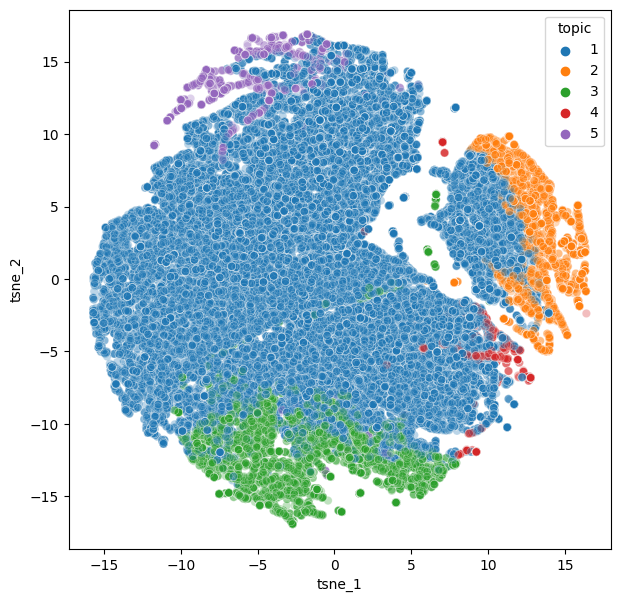

In [51]:
###### Fig. 4 in the report ########
plt.figure(figsize=(7,7))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="topic",
    palette=sns.color_palette("tab10"),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [52]:
# In this section, we implement PCA on topic vectors to be able to visualise them 
# in 2-D and see similarity and dissimilarity between the topics

# Implement PCA to convert the topic vectors to 2-dimensional dataset
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_topics)

# Extract top 3 eigen vectors
pca_1 = pca_result[:,0]
pca_2 = pca_result[:,1] 
pca_3 = pca_result[:,2]

# Create a separate dataframe with topic number against each
pca_df = pd.DataFrame(pca_result, columns=["pca_1", "pca_2", "pca_3"])
pca_df["topic"] = np.array(topic_modelling_df["topic"])
pca_df

,pca_1,pca_2,pca_3,topic
0,-0.114449,0.308503,0.048490,5
1,-0.036814,0.074425,-0.029488,1
2,-0.013714,-0.024257,0.037317,1
3,-0.051357,0.040985,0.102881,1
4,-0.088226,0.152999,0.105078,1
...,...,...,...,...
120228,0.881639,-0.026072,0.152119,2
120229,-0.040141,-0.001165,-0.064168,1
120230,0.741898,-0.023725,0.112828,2
120231,-0.198464,0.552735,0.157344,5


/var/folders/6_/1l86hk0502d9d046h450ths80000gn/T/ipykernel_26583/1393186653.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='pca_1', ylabel='pca_2'>

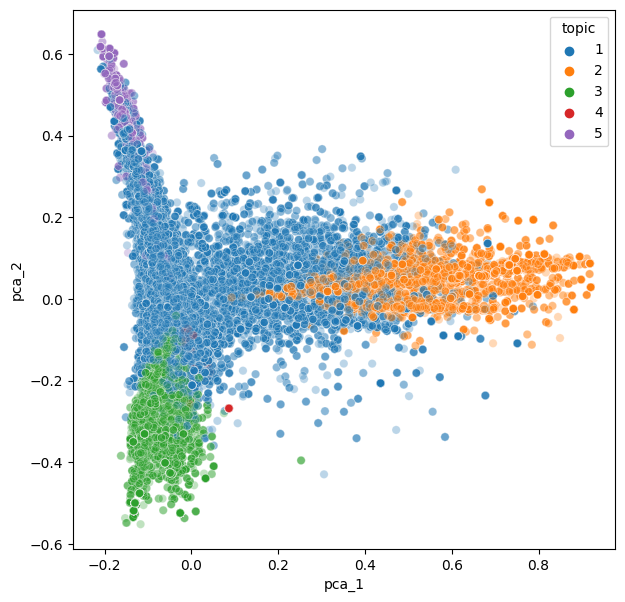

In [55]:
###### Fig. 5 in the report ########
plt.figure(figsize=(7,7))
sns.scatterplot(
    x="pca_1", y="pca_2",
    hue="topic",
    palette=sns.color_palette("tab10"),
    data=pca_df,
    legend="full",
    alpha=0.3
)

In [320]:
# From the above procedure (topic modelling) we realise that the first topic is very dominant
# in the corpus with 78%. 

# We now apply topic modelling again to just this sub-corpus of topic 1.
predicted_sub_topic = perform_lsa(topic_modelling_df[topic_modelling_df["topic"] == 1]['clean_conversation'], 5)


Topic 1: 

payment
loan
account
month
thank
credit
direct
debit

Topic 2: 

payment
direct
debit
change
date
month
make
holiday

Topic 3: 

coach
chat
money
payment
month
change
direct
debit

Topic 4: 

account
bank
credit
image
signature
card
expires
link

Topic 5: 

conversation
started
credit
month
payment
updraft
card
email


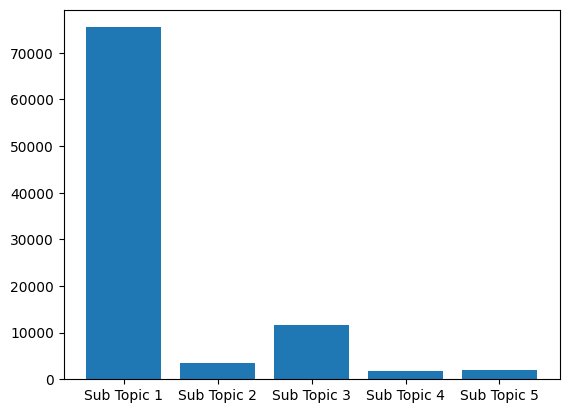

In [325]:
###### Fig. 6 in the report ########

# Visualise the sub-topics with bar chart
list(Counter(predicted_sub_topic).values()) 

D = {"Sub Topic 1": 75485, "Sub Topic 2": 3540, "Sub Topic 3": 11593, "Sub Topic 4": 1678, "Sub Topic 5": 1974}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))

plt.show()

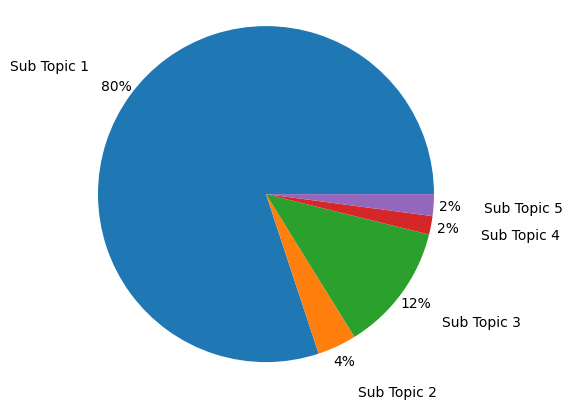

In [326]:
###### Fig. 7 in the report ########

# Plot the above bar plot as pie chart in terms of percentage
labels = []
sizes = []
for x, y in D.items():
    labels.append(x)
    sizes.append(y)

plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.axis('equal')
plt.show()

In [111]:
# We now implement LSI model using the gensim package. 
# Main reason behind this is to verify that our assumption above for 5 topics is not very far off (quantatively)

# Create a separate series
conversations = topic_modelling_df['clean_conversation']

# Apply tokenization
conversations_tok = conversations.apply(lambda x: x.split())

In [112]:
# Create dictionary and corpus
common_dictionary = Dictionary(conversations_tok)
common_corpus = [common_dictionary.doc2bow(text) for text in conversations_tok]

# Fit TF IDF
tfidf = TfidfModel(common_corpus, smartirs="npu")
corpus_tfidf = tfidf[common_corpus]

# Calculate coherence score using LSI model
def compute_coherence_UMass(corpus, dictionary, k):
   lsi_model = LsiModel(corpus=corpus_tfidf, num_topics=k)
   coherence = CoherenceModel(model=lsi_model,
                              corpus=corpus,
                              dictionary=dictionary,
                              coherence='u_mass')
   score = coherence.get_coherence()
   tup = k, score
   return tup

# For n topics from 2 to 10, compare coherence score
coherenceList_UMass = []
numTopicsList = [2,3,4,5,6,7,8,9,10]
for k in numTopicsList:
   c_UMass = compute_coherence_UMass(corpus_tfidf, common_dictionary, k)
   coherenceList_UMass.append(c_UMass)

coherenceList_UMass

[(2, -2.189592591835768),
 (3, -2.158439629912734),
 (4, -2.641703796561254),
 (5, -2.721367574059983),
 (6, -2.542737476287945),
 (7, -2.912857561899774),
 (8, -3.5691049504048906),
 (9, -3.145615850584505),
 (10, -3.205333348478665)]

<Axes: xlabel='n_topics'>

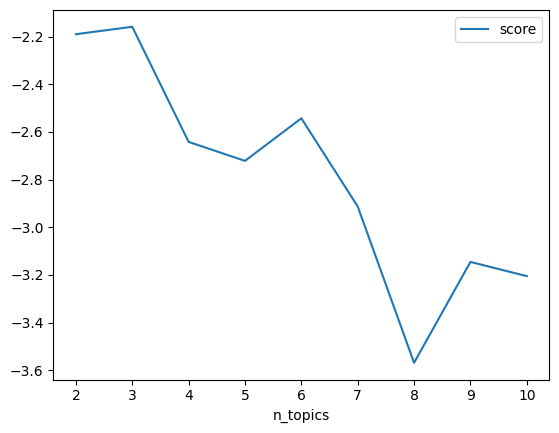

In [113]:
###### Fig. 8 in the report ########

# Visualise the coherence scores for each topic as a line chart
results = pd.DataFrame(coherenceList_UMass, columns=['n_topics', 'score'])
results.plot(x="n_topics", y="score")

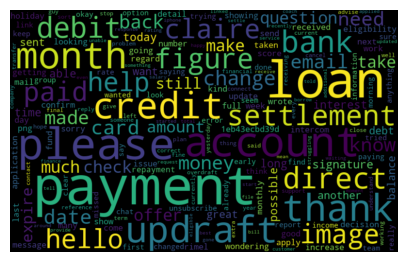

In [329]:
###### Fig. 9 in the report ########

# Word cloud of all words in the corpus
all_words = " ".join([text for text in topic_modelling_df["clean_conversation"]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, collocations=False).generate(all_words)

plt.figure(figsize=(5,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
###### Fig. 10, 11, 12, 13, 14 in the report ########

# Word cloud of all words for a specific topic
all_words = " ".join([text for text in topic_modelling_df[topic_modelling_df["topic"]==4]["clean_conversation"]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, collocations=False).generate(all_words)

plt.figure(figsize=(5,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

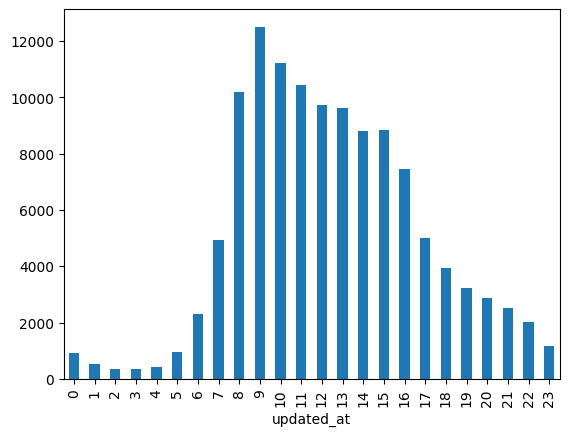

In [201]:
# In this section we perform exploratory analysis to better understand
# our conversation corpus. We also make use of the topics discovered above 
# and perform more analysis.

###### Fig. 15 in the report ########
data = topic_modelling_df.groupby([topic_modelling_df["updated_at"].dt.hour])["id"].count()
data.plot.bar()

plt.show()

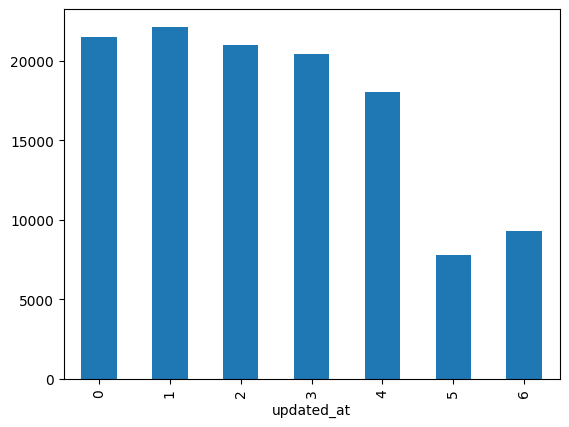

In [163]:
###### Fig. 16 in the report ########
data = topic_modelling_df.groupby([topic_modelling_df['updated_at'].dt.dayofweek])["id"].count()
data.plot.bar()
plt.show()

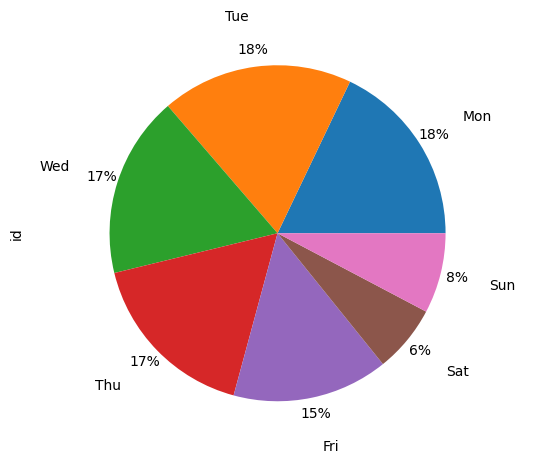

In [167]:
###### Fig. 17 in the report ########
data.plot.pie(labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)

plt.axis('equal')
plt.show()

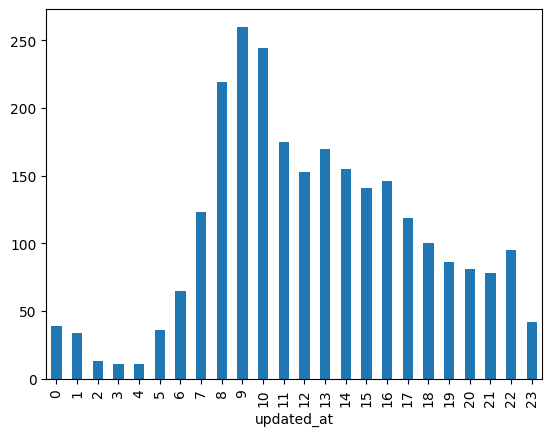

In [212]:
# We now see if each topic has different pattern of distribution of conversations for each hour of the day

###### Fig. 18, 19, 20, 21, 22 in the report ########
data = topic_modelling_df.groupby([topic_modelling_df['topic'], topic_modelling_df['updated_at'].dt.hour])["id"].count()
# Change this index from 0 to 4 to each output for each topic
data[4].plot.bar()

plt.show()

In [228]:
# We now see if each topic has different pattern of distribution of conversations for each day of week
data = topic_modelling_df.groupby([topic_modelling_df['topic'], topic_modelling_df['updated_at'].dt.dayofweek])["id"].count()
# Change this index from 0 to 4 to each output for each topic
data[4].plot.bar()

plt.show()

<Axes: ylabel='Frequency'>

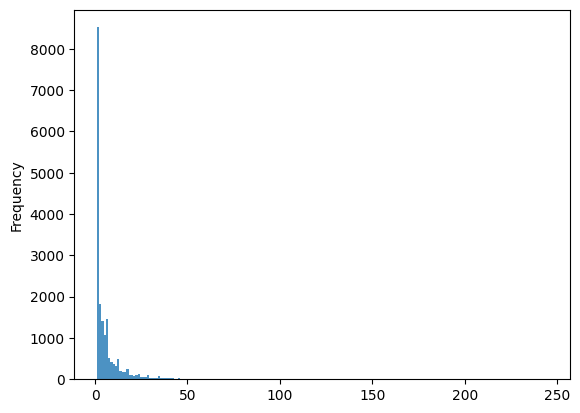

In [254]:
###### Fig. 23 in the report ########
topic_modelling_df.groupby(topic_modelling_df["user"]).count()["id"].plot.hist(bins=200, alpha=0.8)

<Axes: ylabel='Frequency'>

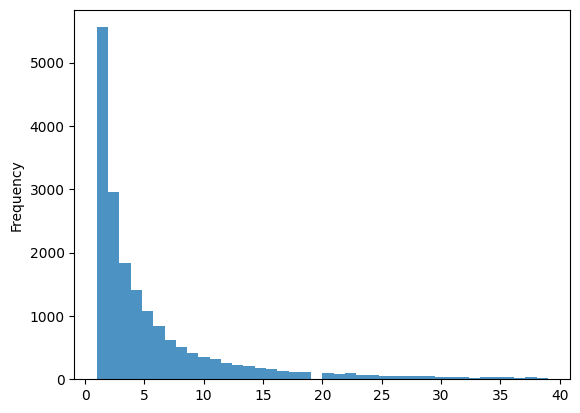

In [59]:
###### Fig. 24 in the report ########
n_conversations_per_user = topic_modelling_df.groupby(topic_modelling_df["user"]).count()["id"]
n_conversations_per_user[n_conversations_per_user < 40].plot.hist(bins=40, alpha=0.8)

In [ ]:
# In this section we perform sentiment analysis using existing libraries as we don't have labels to train on.
# We use three different techniques - 
# 1. VADER
# 2. Transformer model by Hugging Face (Default)
# 3. Transformer model by Higging Face (bertweet-base-sentiment-analysis)

In [73]:
# VADER (Rule based approach)

# Download the nltk module
nltk.download("vader_lexicon")

# Initialize the sentiment analyzer
vds = SentimentIntensityAnalyzer()

# Extract the negative sentiment polarity score
def neg_sentiment_score(row):
    return vds.polarity_scores(row["clean_conversation"])["neg"]

topic_modelling_df["negative_sentiment"] = topic_modelling_df.apply(neg_sentiment_score, axis=1)

# Extract the neutral sentiment polarity score
def neu_sentiment_score(row):
    return vds.polarity_scores(row["clean_conversation"])["neu"]

topic_modelling_df["neutral_sentiment"] = topic_modelling_df.apply(neu_sentiment_score, axis=1)

# Extract the positive sentiment polarity score
def pos_sentiment_score(row):
    return vds.polarity_scores(row["clean_conversation"])["pos"]

topic_modelling_df["positive_sentiment"] = topic_modelling_df.apply(pos_sentiment_score, axis=1)

# Extract the compound score that normalises all the above score and can be used as one single metric.
def compound_sentiment_score(row):
    return vds.polarity_scores(row["clean_conversation"])["compound"]

topic_modelling_df["compound_sentiment"] = topic_modelling_df.apply(compound_sentiment_score, axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/divsaxena/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [332]:
def compound_sentiment_score(row):
    return vds.polarity_scores(row["clean_conversation"])["compound"]

topic_modelling_df["compound_sentiment"] = topic_modelling_df.apply(compound_sentiment_score, axis=1)

In [333]:
def final_sentiment_using_compound(row):
    """
    Define a logic to use compound score and categorise conversations as positive, negative or neutral
    """
    if row['compound_sentiment'] >= 0.70:
        return "Positive"
    elif row['compound_sentiment'] <= - 0.70:
        return "Negative"
    else:
        return "Neutral"

topic_modelling_df["final_sentiment_using_compound"] = topic_modelling_df.apply(final_sentiment_using_compound, axis=1)

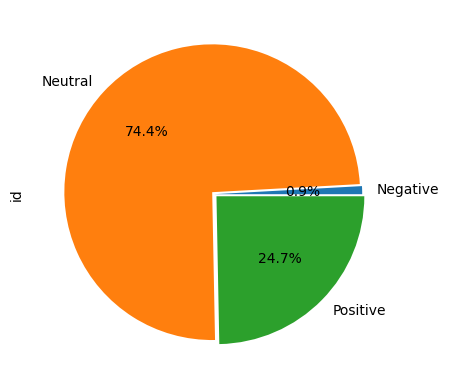

In [334]:
###### Fig. 25 in the report ########
data = topic_modelling_df.groupby("final_sentiment_using_compound").count()["id"] 

data.plot.pie(y='id', legend=False, autopct='%1.1f%%', explode=(0, 0.02, 0.02), shadow=False, startangle=0)
plt.show()

<bound method Artist.remove of <matplotlib.legend.Legend object at 0x4a7754ee0>>

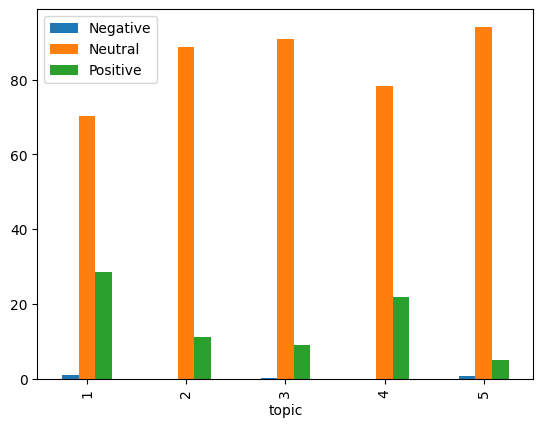

In [335]:
###### Fig. 26 in the report ########
freq_df = topic_modelling_df.groupby(['topic'])['final_sentiment_using_compound'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0) * 100.0
pct_df.fillna(0, inplace=True)
pct_df.plot.bar()
plt.legend().remove

<bound method Artist.remove of <matplotlib.legend.Legend object at 0x373327940>>

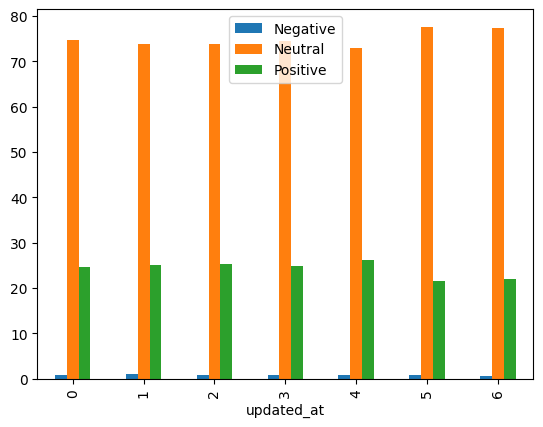

In [337]:
###### Fig. 27 in the report ########
freq_df = topic_modelling_df.groupby([topic_modelling_df['updated_at'].dt.dayofweek])['final_sentiment_using_compound'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0) * 100.0
pct_df.fillna(0, inplace=True)
pct_df.plot.bar()
plt.legend().remove

<bound method Artist.remove of <matplotlib.legend.Legend object at 0x3559898b0>>

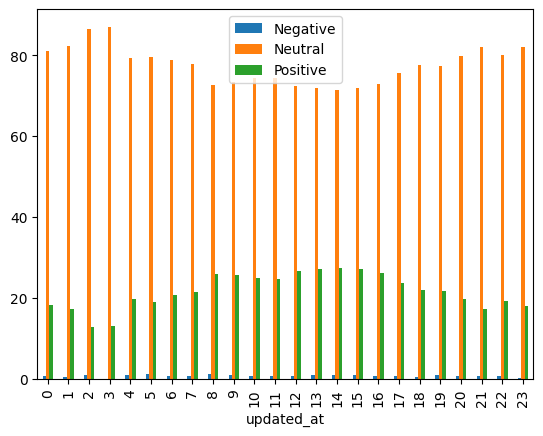

In [338]:
###### Fig. 28 in the report ########
freq_df = topic_modelling_df.groupby([topic_modelling_df['updated_at'].dt.hour])['final_sentiment_using_compound'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0) * 100.0
pct_df.fillna(0, inplace=True)
pct_df.plot.bar()
plt.legend().remove

In [141]:
# Transformer model by Hugging Face (Default)
sentiment_pipeline = pipeline("sentiment-analysis")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9994569420814514},
 {'label': 'NEGATIVE', 'score': 0.9987301230430603}]

In [ ]:
# This transformer model has a contraint that it cannot work with documents with more than 512 tokens
# So, we catch the exception and create a new dummy sentiment NOT FOUND to tackle such cases
output = []
for count, conversation in enumerate(list(topic_modelling_df["clean_conversation"])):
    try:
        sentiment = sentiment_pipeline(conversation)[0]["label"]
    except Exception:
        sentiment = "NOT FOUND"
    
    output.append(sentiment)

In [190]:
# Add the output as a new column to the topic modelling output datafram
topic_modelling_df["transformer_sentiment"] = np.array(output)
topic_modelling_df.groupby("transformer_sentiment").count()["id"]

transformer_sentiment
NEGATIVE     89943
NOT FOUND      686
POSITIVE     29604
Name: id, dtype: int64

In [ ]:
###### Fig. 29 in the report ########
data = topic_modelling_df.groupby("transformer_sentiment").count()["id"]
data.plot.pie(y='id', legend=False, autopct='%1.1f%%', explode=(0, 0.02, 0.02), shadow=False, startangle=0)

In [ ]:
###### Fig. 30 in the report ########
freq_df = topic_modelling_df.groupby(['topic'])['transformer_sentiment'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0) * 100.0
pct_df.fillna(0, inplace=True)
pct_df.plot.bar()
plt.legend().remove

In [ ]:
###### Fig. 31 in the report ########
freq_df = topic_modelling_df.groupby([topic_modelling_df['updated_at'].dt.hour])['transformer_sentiment'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0) * 100.0
pct_df.fillna(0, inplace=True)
pct_df.plot.bar()
plt.legend().remove

In [ ]:
###### Fig. 32 in the report ########
freq_df = topic_modelling_df.groupby([topic_modelling_df['updated_at'].dt.dayofweek])['transformer_sentiment'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0) * 100.0
pct_df.fillna(0, inplace=True)
pct_df.plot.bar()
plt.legend().remove

In [261]:
# Transformer model by Higging Face (bertweet-base-sentiment-analysis)
sentiment_pipeline_2 = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [276]:
# This transformer model has a contraint that it cannot work with documents with more than 512 tokens
# So, we catch the exception and create a new dummy sentiment NOT FOUND to tackle such cases
output_2 = []
total = len(list(topic_modelling_df["clean_conversation"]))
for count, conversation in enumerate(list(topic_modelling_df["clean_conversation"])):
    clear_output(wait=True)
    try:
        sentiment = sentiment_pipeline_2(conversation)[0]["label"]
    except Exception:
        sentiment = "NOT FOUND"
    
    output_2.append(sentiment)
    print("Current Progress: ", np.round(count/total * 100, 2), "%")

Current Progress:  100.0 %


In [281]:
topic_modelling_df["transformer_2_sentiment"] = np.array(output_2)
data = topic_modelling_df.groupby("transformer_2_sentiment").count()["id"]

transformer_2_sentiment
NEG          11533
NEU          90684
NOT FOUND     5070
POS          12946
Name: id, dtype: int64

<Axes: ylabel='id'>

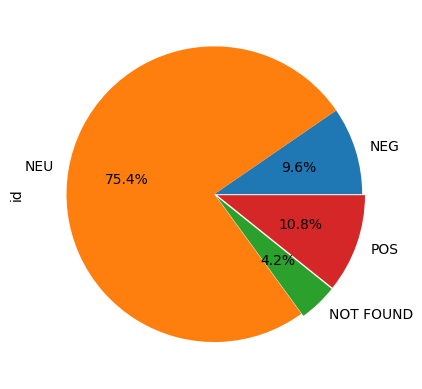

In [282]:
###### Fig. 33 in the report ########
data.plot.pie(y='id', legend=False, autopct='%1.1f%%', explode=(0, 0, 0.02, 0.02), shadow=False, startangle=0)

<bound method Artist.remove of <matplotlib.legend.Legend object at 0x4614045b0>>

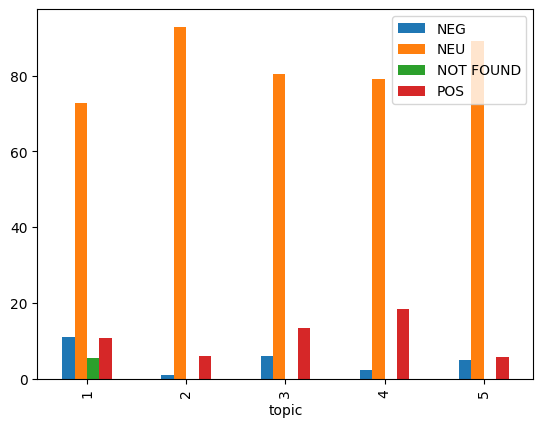

In [283]:
###### Fig. 34 in the report ########
freq_df = topic_modelling_df.groupby(['topic'])['transformer_2_sentiment'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0) * 100.0
pct_df.fillna(0, inplace=True)
pct_df.plot.bar()
plt.legend().remove

<bound method Artist.remove of <matplotlib.legend.Legend object at 0x4a5f423d0>>

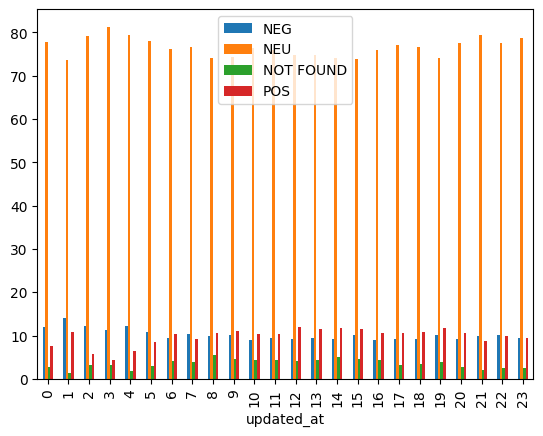

In [285]:
###### Fig. 35 in the report ########
freq_df = topic_modelling_df.groupby([topic_modelling_df['updated_at'].dt.hour])['transformer_2_sentiment'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0) * 100.0
pct_df.fillna(0, inplace=True)
pct_df.plot.bar()
plt.legend().remove

<bound method Artist.remove of <matplotlib.legend.Legend object at 0x4a5f2c8b0>>

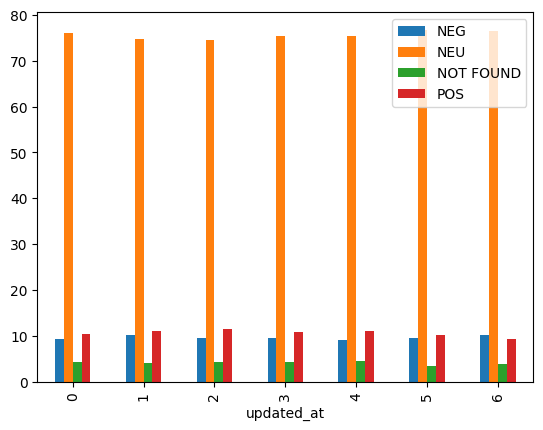

In [284]:
###### Fig. 36 in the report ########
freq_df = topic_modelling_df.groupby([topic_modelling_df['updated_at'].dt.dayofweek])['transformer_2_sentiment'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0) * 100.0
pct_df.fillna(0, inplace=True)
pct_df.plot.bar()
plt.legend().remove